In [ ]:
# Change in the text data with time even with the country-year fixed effects is noteworthy.
# I checked that the increasing emphasis on international rule of law is the driving force behind this change.
# This change was detected by getting the first latent factor which positively correlates with time.


In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import plotly.express as px

# Load data
df = pd.read_csv("predictions/q69_predictions_filtered.csv")

q69_labels = ['Q69_1', 'Q69_2', 'Q69_3', 'Q69_4']
df_q69 = df[df['predicted_combined_label'].isin(q69_labels)].copy()

# Compute embeddings for each sentence
model = SentenceTransformer('all-mpnet-base-v2')
sentences = df_q69['sentence'].tolist()
print("Computing embeddings for sentences...")
embeddings = model.encode(sentences, show_progress_bar=True)
df_q69['embedding'] = list(embeddings)

# Aggregate embeddings per country-year by mean
def mean_embedding(emb_list):
    return np.mean(np.vstack(emb_list), axis=0)

agg_emb = (
    df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['embedding']
    .apply(mean_embedding)
    .reset_index()
)

# Aggregate sentence counts and proportions
agg_counts = (
    df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label'])
    .size()
    .reset_index(name='sentence_count')
)
total_counts = (
    agg_counts.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count']
    .sum()
    .reset_index(name='total_q69_count')
)
agg_counts = agg_counts.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
agg_counts['proportion'] = agg_counts['sentence_count'] / agg_counts['total_q69_count']

agg_q69_1 = agg_counts[agg_counts['predicted_combined_label'] == 'Q69_1'].copy()

# Make sure year types match for merging
agg_q69_1['A_YEAR'] = agg_q69_1['A_YEAR'].astype(str)
agg_emb['A_YEAR'] = agg_emb['A_YEAR'].astype(str)

# Merge embeddings with proportions
agg_merged = agg_q69_1.merge(agg_emb, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

# Extract latent factors using PCA
X = np.vstack(agg_merged['embedding'].values)
pca = PCA(n_components=10)
latent_factors = pca.fit_transform(X)

for i in range(latent_factors.shape[1]):
    agg_merged[f'latent_factor_{i+1}'] = latent_factors[:, i]

# Convert year to numeric for correlation
agg_merged['A_YEAR_num'] = agg_merged['A_YEAR'].astype(int)

# Calculate and print correlations between latent factors and year
for i in range(1, 11):
    corr = agg_merged[f'latent_factor_{i}'].corr(agg_merged['A_YEAR_num'])
    print(f'Correlation of latent_factor_{i} with year: {corr:.3f}')

Computing embeddings for sentences...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Correlation of latent_factor_1 with year: 0.161
Correlation of latent_factor_2 with year: -0.213
Correlation of latent_factor_3 with year: -0.005
Correlation of latent_factor_4 with year: 0.012
Correlation of latent_factor_5 with year: -0.110
Correlation of latent_factor_6 with year: 0.014
Correlation of latent_factor_7 with year: -0.051
Correlation of latent_factor_8 with year: 0.106
Correlation of latent_factor_9 with year: -0.307
Correlation of latent_factor_10 with year: 0.089


Computing embeddings for sentences...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Correlation between residual latent_factor_1 and mean semantic shift: 0.422


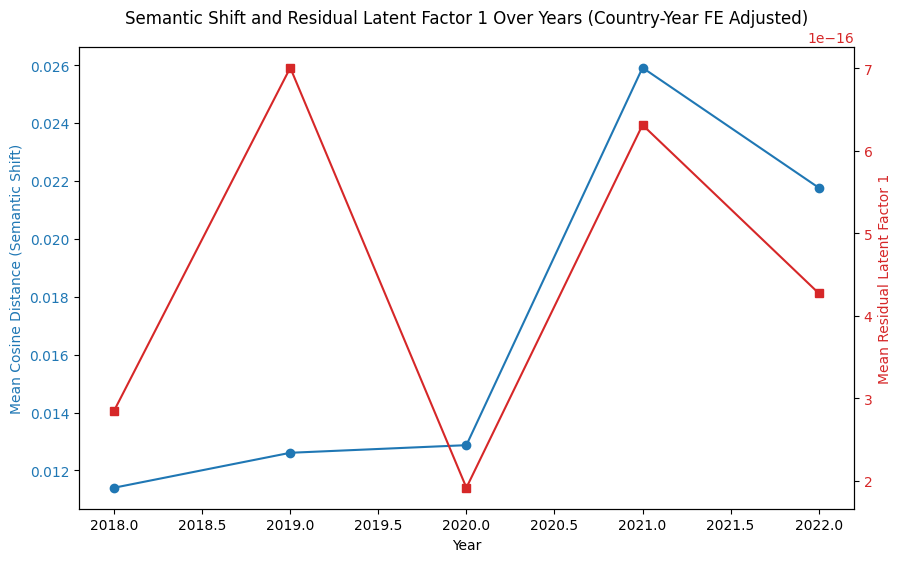

In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_csv("predictions/q69_predictions_filtered.csv")

q69_labels = ['Q69_1', 'Q69_2', 'Q69_3', 'Q69_4']
df_q69 = df[df['predicted_combined_label'].isin(q69_labels)].copy()

# Step 2: Compute sentence embeddings
model = SentenceTransformer('all-mpnet-base-v2')
sentences = df_q69['sentence'].tolist()
print("Computing embeddings for sentences...")
embeddings = model.encode(sentences, show_progress_bar=True)
df_q69['embedding'] = list(embeddings)

# Step 3: Aggregate embeddings per country-year
def mean_embedding(emb_list):
    return np.mean(np.vstack(emb_list), axis=0)

agg_emb = (
    df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['embedding']
    .apply(mean_embedding)
    .reset_index()
)

# Step 4: Aggregate sentence counts and proportions
agg_counts = (
    df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label'])
    .size()
    .reset_index(name='sentence_count')
)
total_counts = (
    agg_counts.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count']
    .sum()
    .reset_index(name='total_q69_count')
)
agg_counts = agg_counts.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
agg_counts['proportion'] = agg_counts['sentence_count'] / agg_counts['total_q69_count']

agg_q69_1 = agg_counts[agg_counts['predicted_combined_label'] == 'Q69_1'].copy()

# Step 5: Fix dtypes for merging
agg_q69_1['A_YEAR'] = agg_q69_1['A_YEAR'].astype(str)
agg_emb['A_YEAR'] = agg_emb['A_YEAR'].astype(str)

# Step 6: Merge embeddings with proportions
agg_merged = agg_q69_1.merge(agg_emb, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

# Add numeric year column for grouping
agg_merged['A_YEAR_int'] = agg_merged['A_YEAR'].astype(int)

# Step 7: Extract latent factors
X = np.vstack(agg_merged['embedding'].values)
pca = PCA(n_components=3)
latent_factors = pca.fit_transform(X)
for i in range(latent_factors.shape[1]):
    agg_merged[f'latent_factor_{i+1}'] = latent_factors[:, i]

# Step 8: Regress latent_factor_1 on country and year fixed effects
model_fe = smf.ols('latent_factor_1 ~ C(B_COUNTRY_ALPHA) + C(A_YEAR)', data=agg_merged).fit()
agg_merged['latent_factor_1_resid'] = model_fe.resid

# Step 9: Compute mean embeddings per year (all countries)
agg_emb['A_YEAR_int'] = agg_emb['A_YEAR'].astype(int)
mean_emb_by_year = agg_emb.groupby('A_YEAR_int')['embedding'].apply(lambda embs: np.mean(np.vstack(embs), axis=0))
mean_emb_by_year = mean_emb_by_year.sort_index()

# Step 10: Compute cosine distances between consecutive years
years = mean_emb_by_year.index.to_list()
distances = []
for i in range(1, len(years)):
    d = cosine_distances(
        mean_emb_by_year.iloc[i-1].reshape(1, -1),
        mean_emb_by_year.iloc[i].reshape(1, -1)
    )[0][0]
    distances.append(d)

semantic_shift_df = pd.DataFrame({
    'A_YEAR_int': years[1:],
    'mean_cosine_distance': distances
})

# Step 11: Calculate mean residual latent_factor_1 per year
latent_year_avg = agg_merged.groupby('A_YEAR_int')['latent_factor_1_resid'].mean().reset_index()
latent_year_avg.rename(columns={'latent_factor_1_resid': 'mean_latent_factor_1_resid'}, inplace=True)

# Step 12: Merge residual latent_factor_1 with semantic shifts
analysis_df = semantic_shift_df.merge(latent_year_avg, on='A_YEAR_int')

# Step 13: Correlate residual latent_factor_1 and semantic shifts
corr = analysis_df['mean_latent_factor_1_resid'].corr(analysis_df['mean_cosine_distance'])
print(f"Correlation between residual latent_factor_1 and mean semantic shift: {corr:.3f}")

# Step 14: Plot results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Cosine Distance (Semantic Shift)', color=color)
ax1.plot(analysis_df['A_YEAR_int'], analysis_df['mean_cosine_distance'], marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Residual Latent Factor 1', color=color)
ax2.plot(analysis_df['A_YEAR_int'], analysis_df['mean_latent_factor_1_resid'], marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Semantic Shift and Residual Latent Factor 1 Over Years (Country-Year FE Adjusted)')
plt.show()

Computing sentence embeddings...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Themes for high latent_factor_1 sentences:
- peacekeeping faces today years (0.751)
- peacekeepers bangladesh (0.749)
- peacekeeping faces today (0.744)
- challenges peacekeeping faces today (0.730)
- tackle challenges peacekeeping faces (0.723)
- peacekeepers bangladesh supreme (0.722)
- peacekeepers bangladesh supreme sacrifice (0.718)
- contribution united nations peacekeeping (0.712)
- challenges peacekeeping faces (0.705)
- new challenging realities peacekeeping (0.703)


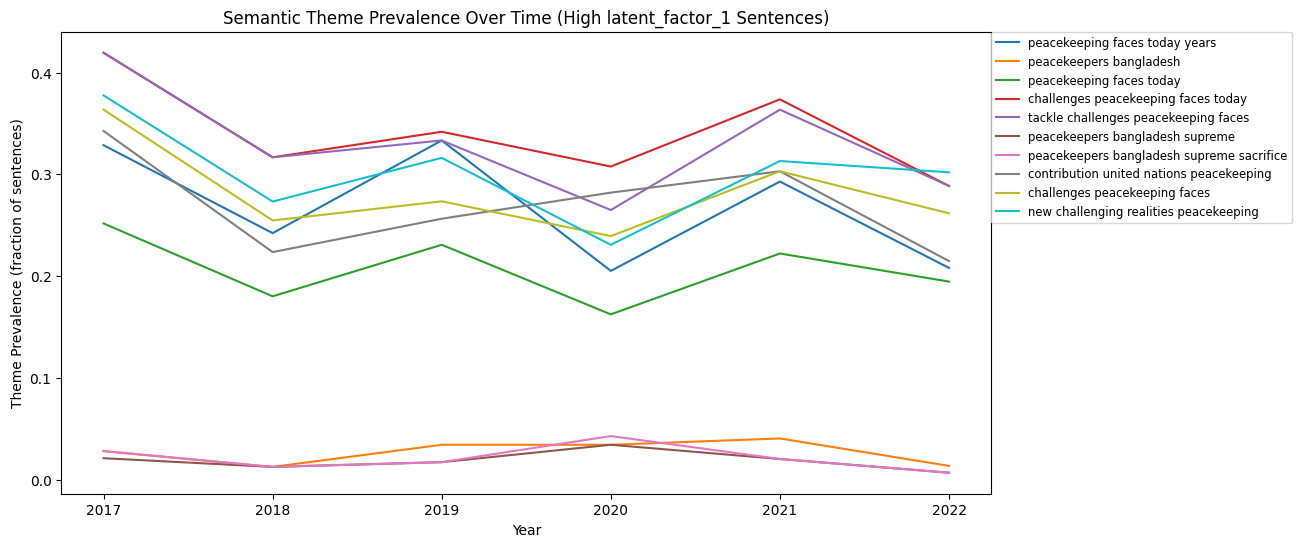

In [6]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

# Load data and filter
df = pd.read_csv("predictions/q69_predictions_filtered.csv")
q69_labels = ['Q69_1', 'Q69_2', 'Q69_3', 'Q69_4']
df_q69 = df[df['predicted_combined_label'].isin(q69_labels)].copy()

# Compute embeddings
model = SentenceTransformer('all-mpnet-base-v2')
print("Computing sentence embeddings...")
df_q69['embedding'] = list(model.encode(df_q69['sentence'].tolist(), show_progress_bar=True))

# Aggregate embeddings per country-year
def mean_embedding(emb_list):
    return np.mean(np.vstack(emb_list), axis=0)
agg_emb = df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['embedding'].apply(mean_embedding).reset_index()

# Aggregate counts and proportions
agg_counts = df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label']).size().reset_index(name='sentence_count')
total_counts = agg_counts.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count'].sum().reset_index(name='total_q69_count')
agg_counts = agg_counts.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
agg_counts['proportion'] = agg_counts['sentence_count'] / agg_counts['total_q69_count']
agg_q69_1 = agg_counts[agg_counts['predicted_combined_label'] == 'Q69_1'].copy()
agg_q69_1['A_YEAR'] = agg_q69_1['A_YEAR'].astype(str)
agg_emb['A_YEAR'] = agg_emb['A_YEAR'].astype(str)
agg_merged = agg_q69_1.merge(agg_emb, on=['B_COUNTRY_ALPHA', 'A_YEAR'])
X = np.vstack(agg_merged['embedding'].values)
pca = PCA(n_components=3)
latent_factors = pca.fit_transform(X)
for i in range(latent_factors.shape[1]):
    agg_merged[f'latent_factor_{i+1}'] = latent_factors[:, i]
agg_factor = agg_merged[['B_COUNTRY_ALPHA', 'A_YEAR', 'latent_factor_1']].copy()
agg_factor['A_YEAR'] = agg_factor['A_YEAR'].astype(str)
df_q69['A_YEAR'] = df_q69['A_YEAR'].astype(str)
df_q69_with_factor = df_q69.merge(agg_factor, on=['B_COUNTRY_ALPHA', 'A_YEAR'], how='left')

# Get top 200 sentences by latent_factor_1
top_pos = df_q69_with_factor.sort_values('latent_factor_1', ascending=False).head(200)

# Extract themes using KeyBERT
kw_model = KeyBERT('all-mpnet-base-v2')
def extract_themes(texts, top_n=10):
    corpus = " ".join(texts)
    return kw_model.extract_keywords(corpus, keyphrase_ngram_range=(1, 4), stop_words='english', top_n=top_n)

themes_pos = extract_themes(top_pos['sentence'].tolist())
print("Themes for high latent_factor_1 sentences:")
for theme, score in themes_pos:
    print(f"- {theme} ({score:.3f})")

# Embed the theme phrases
theme_texts = [t[0] for t in themes_pos]
theme_embeddings = model.encode(theme_texts)

# Compute cosine similarity between every sentence and each theme
sentence_embeddings = np.vstack(df_q69_with_factor['embedding'].values)
similarity_matrix = cosine_similarity(sentence_embeddings, theme_embeddings)

# Set similarity threshold to count a sentence as expressing that theme
threshold = 0.5

# For each theme, compute yearly prevalence: fraction of sentences with similarity > threshold
df_q69_with_factor['A_YEAR_int'] = df_q69_with_factor['A_YEAR'].astype(int)
theme_prevalence = {}
for i, theme in enumerate(theme_texts):
    theme_mask = similarity_matrix[:, i] > threshold
    df_q69_with_factor[f'theme_{i}_match'] = theme_mask
    prevalence = df_q69_with_factor.groupby('A_YEAR_int')[f'theme_{i}_match'].mean()
    theme_prevalence[theme] = prevalence

prevalence_df = pd.DataFrame(theme_prevalence)

# Plot top 10 themes prevalence over time
plt.figure(figsize=(12, 6))
for theme in prevalence_df.columns[:10]:
    plt.plot(prevalence_df.index, prevalence_df[theme], label=theme)

plt.xlabel('Year')
plt.ylabel('Theme Prevalence (fraction of sentences)')
plt.title('Semantic Theme Prevalence Over Time (High latent_factor_1 Sentences)')
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv("predictions/q69_predictions_filtered.csv")

q69_labels = ['Q69_1', 'Q69_2', 'Q69_3', 'Q69_4']
df_q69 = df[df['predicted_combined_label'].isin(q69_labels)]

# Aggregate counts per country, year, and label
agg = df_q69.groupby(['B_COUNTRY_ALPHA', 'A_YEAR', 'predicted_combined_label']).size().reset_index(name='sentence_count')

# Total sentences per country-year (all Q69)
total_counts = agg.groupby(['B_COUNTRY_ALPHA', 'A_YEAR'])['sentence_count'].sum().reset_index(name='total_q69_count')

agg = agg.merge(total_counts, on=['B_COUNTRY_ALPHA', 'A_YEAR'])

agg['proportion'] = agg['sentence_count'] / agg['total_q69_count']

# Filter for Q69_1 only
agg_q69_1 = agg[agg['predicted_combined_label'] == 'Q69_1'].copy()

# Fit OLS with country and year fixed effects (categorical)
model = smf.ols('proportion ~ C(B_COUNTRY_ALPHA) + C(A_YEAR)', data=agg_q69_1).fit()

# Add fitted (adjusted) values and residuals
agg_q69_1['fitted_proportion'] = model.fittedvalues
agg_q69_1['residuals'] = model.resid

# Create combined country-year string for x-axis
agg_q69_1['COUNTRY_YEAR'] = agg_q69_1['B_COUNTRY_ALPHA'] + ' ' + agg_q69_1['A_YEAR'].astype(str)

agg_q69_1['COUNTRY_YEAR'] = pd.Categorical(
    agg_q69_1['COUNTRY_YEAR'],
    categories=sorted(agg_q69_1['COUNTRY_YEAR'].unique()),
    ordered=True
)

# Plot adjusted (fitted) proportions
fig = px.scatter(
    agg_q69_1,
    x='COUNTRY_YEAR',
    y='fitted_proportion',
    size='sentence_count',
    color='B_COUNTRY_ALPHA',
    hover_name='COUNTRY_YEAR',
    labels={
        'COUNTRY_YEAR': 'Country Year',
        'fitted_proportion': 'Adjusted Proportion of Q69_1',
        'sentence_count': 'Sentence Count'
    },
    title='Adjusted Proportion of Q69_1 Sentences (Year & Country Fixed Effects)',
    size_max=40,
    height=600
)

fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': sorted(agg_q69_1['COUNTRY_YEAR'].unique())},
    legend_title_text='Country',
    margin=dict(l=40, r=40, t=80, b=40),
    xaxis_tickangle=45
)

fig.show()